# Trabalho 01 - Gama de cores

O arquivo `all_1nm_data.xls` fornece as curvas x̄(λ),ȳ(λ),z̄(λ) e os espectro do iluminante CIE D65, Lw(λ), que aproxima a luz solar. A radiância refletida numa superfície é caracterizada pelo produto, ponto a ponto, do espectro Lw, com o coeficiente de reflexão β(λ) do material da superfície.

Pede-se:

1) Considerando todas as possíveis curvas de coeficiente de reflexão β(λ) determine o conjunto de todas as cores possíveis para uma superfície iluminada pelo D65. Esse conjunto de pontos representa a Gama (Gamut) de cores visíveis. Busque as cores da borda deste conjunto e mostre uma imagem 3D gerado.
2) Projete essas cores no plano X+Y+Z=1 e gere a figura da ferradura no plano CIE xyY.
3) Transforme as coordenadas de todas as cores visíveis do papel do CIE XYZ para o sistema CIE Lab, e mostre a forma do sólido gerado.
4) Transforme as coordenadas de todas as cores visíveis do papel do CIE XYZ para o sistema sRGB, e mostre a forma do sólido gerado. Quais destas cores podem ser vistas num monitor sRGB?
5) Mostre nos espaços CIE XYZ, CIE xyY e CIE Lab apenas as cores que podem ser exibidas num dispositivo sRGB.

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import animation
import scipy
from scipy import ndimage
import time
import skimage.color as skc

#### Lendo os dados dos arquivos disponibilizados

In [6]:
DATA_PATH = ''
DATA_NAME = 'all_1nm_data.xls'
DATA_MOD_NAME = 'all_1nm_data_mod.xls'
file_path = DATA_PATH + DATA_NAME

In [18]:
sheet_name = 'all @ 1 nm'
df = pd.read_excel(file_path, sheet_name = sheet_name, skiprows = [0,1,2])
df = df[(df['nm'] > 379 )&(df['nm'] < 781) ]
df = df[['nm', 'CIE D65', 'x bar', 'y bar', 'z bar']].copy()
df.reset_index()

In [28]:
nm = df['nm']
Lw = df['CIE D65']
x_ = df['x bar']
y_ = df['y bar']
z_ = df['z bar']

Lw = Lw/np.amax(Lw)

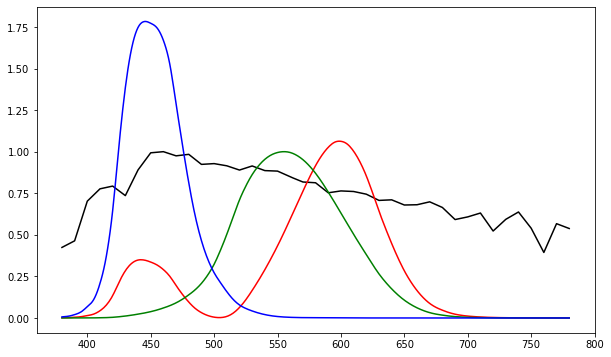

In [30]:
fig = plt.figure(figsize=(10,6))
plt.plot(nm, Lw, 'k')
plt.plot(nm, x_, 'r')
plt.plot(nm, y_, 'g')
plt.plot(nm, z_, 'b')

In [34]:
def beta2XYZ(Lw, beta, x_, y_, z_):
    kw = 1.0/np.sum(Lw*y_)
    X = kw*np.sum(Lw*beta*x_)
    Y = kw*np.sum(Lw*beta*y_)
    Z = kw*np.sum(Lw*beta*z_)
    return np.array([X,Y,Z])

In [32]:
def gamma_sRGB(x):
    t = x if x>0 else -x
    
    if t>0.0031308:
        gamma = 1.055*pow(t,1.0/2.4)-0.055
    else:
        gamma = 12.92*t
    return gamma if x>0 else -gamma

def XYZ_to_sRGB(XYZ):
    reference_white_D65 = [0.95047, 1.0, 1.08883]
    xr = XYZ[0]/reference_white_D65[0]
    yr = XYZ[1]/reference_white_D65[1]
    zr = XYZ[2]/reference_white_D65[2]
    
    r = 3.2404542*xr - 1.5371385*yr - 0.4985314*zr
    g = -0.9692660*xr + 1.8760108*yr + 0.0415560*zr
    b = 0.0556434*xr - 0.2040256*yr + 1.0572252*zr
    
    r = gamma_sRGB(r)
    g = gamma_sRGB(g)
    b = gamma_sRGB(b)
    return [r,g,b]

## 1. Conjunto de pontos que representa a Gama (Gamut) de cores visíveis

In [35]:
# lista de cores
CIEXYZ = [[0,0,0]] 

# lista de valores para lambdaM e deltaLambda
sRGB = [[0,0,0]] 

# array com números de 1 a 401
vals = np.linspace(1,401,400).astype(np.int32) 

beta = np.zeros(401)
for delta in vals:
    beta[:delta]=1
    # controla deltaLambda com shifts
    for shift in vals:
        # move o valor 1 de beta no delta entre todos os elementos
        beta_s=np.roll(beta,shift)
        corXYZ = beta2XYZ(Lw,beta_s,x_,y_,z_)
        corRGB = XYZ_to_sRGB(corXYZ)
        # adiciona nos vetores
        CIEXYZ.append(corXYZ)
        sRGB.append(corRGB)
        
beta_w = np.ones(401)
W_XYZ = beta2XYZ(Lw, beta_w,x_,y_,z_)
W_sRGB = XYZ_to_sRGB(W_XYZ)

CIEXYZ.append(W_XYZ)
sRGB.append(W_sRGB)
CIEXYZ = np.array(CIEXYZ)
sRGB = np.array(sRGB)

# cores não representaveis em RGB passam dos valores de 0 e 1
# clip remove eles elementos e os transforma em 0 (se menores que 0) ou 1 (se maiores que 1)
sRGB_clip = np.clip(sRGB, 0, 1)

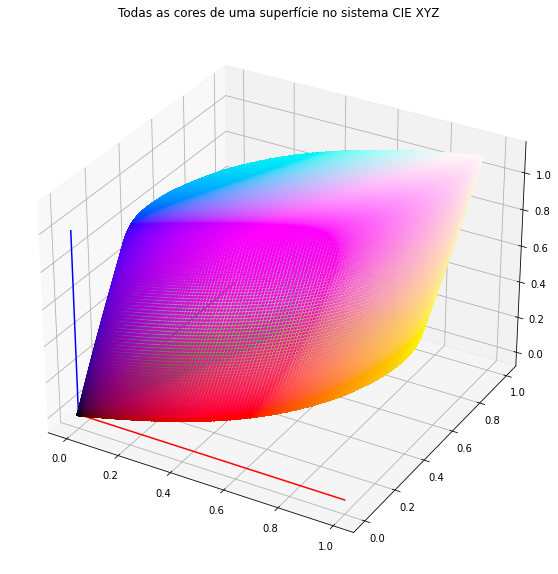

In [38]:
fig = plt.figure(figsize=[15,10])
ax=fig.add_subplot(111, projection = '3d')
ax.scatter(CIEXYZ[:,0], CIEXYZ[:,1], CIEXYZ[:,2], c=sRGB_clip, s=5)
plt.title('Todas as cores de uma superfície no sistema CIE XYZ')
ax.plot([0,1],[0,0],[0,0],'red')
ax.plot([0,0],[0,1],[0,0],'green')
ax.plot([0,0],[0,0],[0,1],'blue')

## 2. Projeção das cores no plano X+Y+Z=1

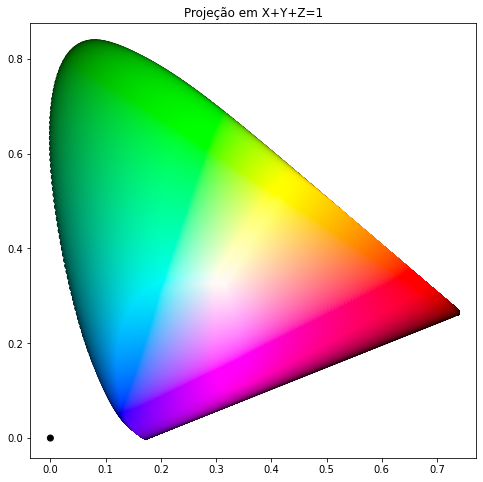

In [56]:
CIE_xyY = np.zeros(CIEXYZ.shape)

SUM = np.sum(CIEXYZ, axis=1)
SUM[SUM<=0] = 1

CIE_xyY[:,0] = CIEXYZ[:,0]/SUM
CIE_xyY[:,1] = CIEXYZ[:,1]/SUM
CIE_xyY[:,2] = CIEXYZ[:,1]

fig = plt.figure(figsize=(8,8))
plt.title('Projeção em X+Y+Z=1')
plt.scatter(CIE_xyY[:,0],CIE_xyY[:,1], color=sRGB_clip)

## 3. Transformação de CIE XYZ para o sistema CIE Lab

In [53]:
CIELab = skc.xyz2lab(CIEXYZ)

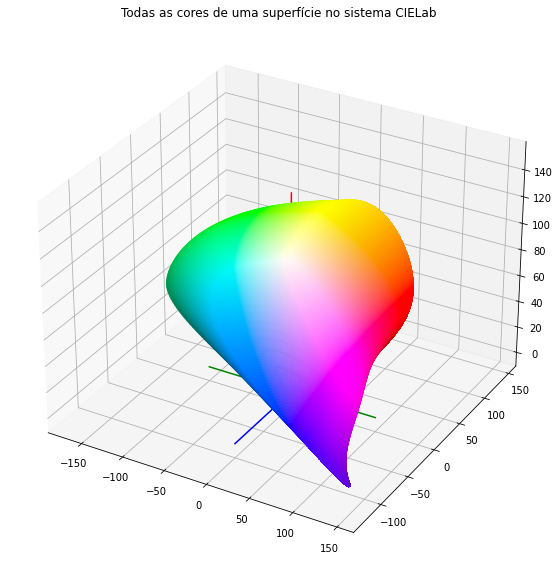

In [60]:
fig = plt.figure(figsize=[15,10])
ax=fig.add_subplot(111, projection = '3d')
ax.scatter(CIELab[:,1], CIELab[:,2], CIELab[:,0], c=sRGB_clip, s=5)
plt.title('Todas as cores de uma superfície no sistema CIELab')
ax.plot([-100,100],[0,0],[0,0],'green')
ax.plot([0,0],[-100,100],[0,0],'blue')
ax.plot([0,0],[0,0],[0,150],'red')

## 4. Transformação das coordenadas de CIE XYZ para o sistema sRGB

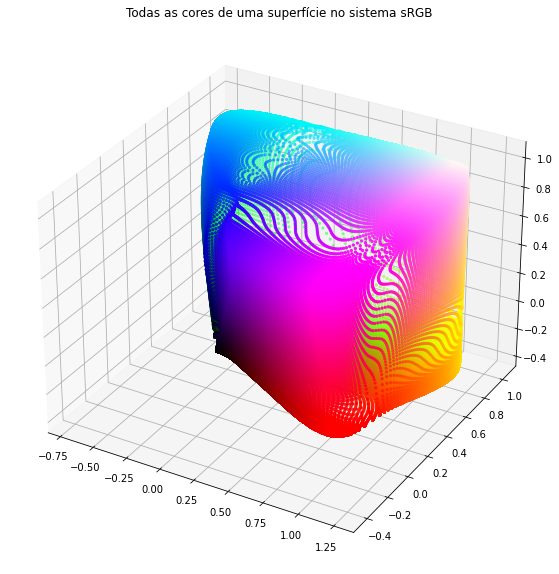

In [57]:
fig = plt.figure(figsize=[15,10])
ax=fig.add_subplot(111, projection = '3d')
ax.scatter(sRGB[:,0], sRGB[:,1], sRGB[:,2], c=sRGB_clip, s=5)
plt.title('Todas as cores de uma superfície no sistema sRGB')
ax.plot([0,1],[0,0],[0,0],'red')
ax.plot([0,0],[0,1],[0,0],'green')
ax.plot([0,0],[0,0],[0,1],'blue')

## 5. Cores exibidas num dispositivo sRGB

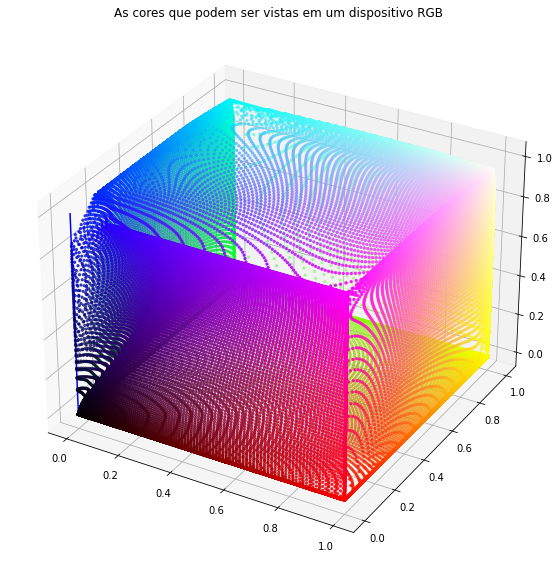

In [61]:
fig = plt.figure(figsize=[15,10])
ax=fig.add_subplot(111, projection = '3d')
ax.scatter(sRGB_clip[:,0], sRGB_clip[:,1], sRGB_clip[:,2], c=sRGB_clip, s=5)
plt.title('As cores que podem ser vistas em um dispositivo RGB')
ax.plot([0,1],[0,0],[0,0],'red')
ax.plot([0,0],[0,1],[0,0],'green')
ax.plot([0,0],[0,0],[0,1],'blue')

As cores que podem ser vistas em um dispositivo RGB são representadas pelo cubo acima. 

In [62]:
NEWCOLORS = skc.lab2rgb(CIELab)

In [65]:
rgbLab_clip = np.clip(NEWCOLORS, 0, 1)

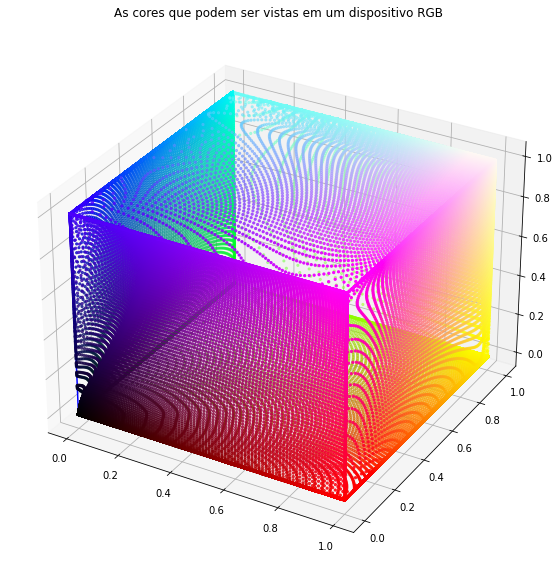

In [66]:
fig = plt.figure(figsize=[15,10])
ax=fig.add_subplot(111, projection = '3d')
ax.scatter(rgbLab_clip[:,0], rgbLab_clip[:,1], rgbLab_clip[:,2], c=sRGB_clip, s=5)
plt.title('As cores que podem ser vistas em um dispositivo RGB')
ax.plot([0,1],[0,0],[0,0],'red')
ax.plot([0,0],[0,1],[0,0],'green')
ax.plot([0,0],[0,0],[0,1],'blue')